:Clone the repository from GitHub:

In [2]:
!git clone https://github.com/maziarraissi/PINNs.git

Cloning into 'PINNs'...
remote: Enumerating objects: 741, done.
remote: Total 741 (delta 0), reused 0 (delta 0), pack-reused 741
Receiving objects: 100% (741/741), 474.47 MiB | 20.74 MiB/s, done.
Resolving deltas: 100% (66/66), done.
Updating files: 100% (561/561), done.


Mount Google Drive:

In [4]:
# Load the data

from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
import matplotlib.pyplot as plt

Iteration: 0, Loss: 3.771e-03
Iteration: 10, Loss: 3.771e-03
Iteration: 20, Loss: 3.771e-03
Iteration: 30, Loss: 3.771e-03
Iteration: 40, Loss: 3.771e-03
Iteration: 50, Loss: 3.771e-03
Iteration: 60, Loss: 3.771e-03
Iteration: 70, Loss: 3.771e-03
Iteration: 80, Loss: 3.771e-03
Iteration: 90, Loss: 3.771e-03
Iteration: 100, Loss: 3.771e-03
Iteration: 110, Loss: 3.771e-03
Iteration: 120, Loss: 3.771e-03
Iteration: 130, Loss: 3.771e-03
Iteration: 140, Loss: 3.771e-03
Iteration: 150, Loss: 3.771e-03
Iteration: 160, Loss: 3.771e-03
Iteration: 170, Loss: 3.771e-03
Iteration: 180, Loss: 3.771e-03
Iteration: 190, Loss: 3.771e-03
Iteration: 200, Loss: 3.771e-03
Iteration: 210, Loss: 3.771e-03
Iteration: 220, Loss: 3.771e-03
Iteration: 230, Loss: 3.771e-03
Iteration: 240, Loss: 3.771e-03
Iteration: 250, Loss: 3.771e-03
Iteration: 260, Loss: 3.771e-03
Iteration: 270, Loss: 3.771e-03
Iteration: 280, Loss: 3.771e-03
Iteration: 290, Loss: 3.771e-03
Iteration: 300, Loss: 3.771e-03
Iteration: 310, Los

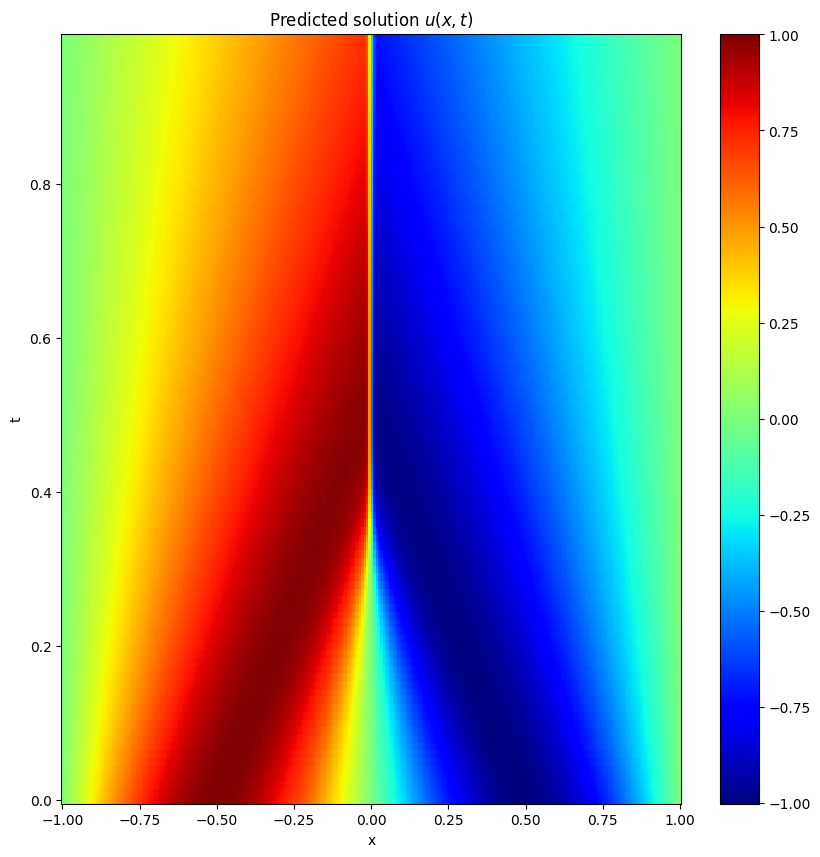

In [23]:
#Import necessary libraries:
import torch
import numpy as np
import scipy.io
from collections import OrderedDict
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import warnings

#Ignore warnings:
warnings.filterwarnings('ignore')

#Set the random seed:
np.random.seed(1234)

#Check for CUDA availability and set the device
# CUDA support
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

#Define the Deep Neural Network (DNN) class:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()

        self.depth = len(layers) - 1

        self.activation = torch.nn.Tanh

        layer_list = list()
        for i in range(self.depth - 1):
            layer_list.append(('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1])))
            layer_list.append(('activation_%d' % i, self.activation()))

        layer_list.append(('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1])))

        layer_dict = OrderedDict(layer_list)
        self.layers = torch.nn.Sequential(layer_dict)

    def forward(self, x):
        out = self.layers(x)
        return out

# the physics-guided neural network
# Define the PhysicsInformedNN class:
class PhysicsInformedNN():
    def __init__(self, X, u, layers, lb, ub):

        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)

        self.x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        self.t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)

        self.lambda_1 = torch.tensor([0.0], requires_grad=True).to(device)
        self.lambda_2 = torch.tensor([-6.0], requires_grad=True).to(device)

        self.lambda_1 = torch.nn.Parameter(self.lambda_1)
        self.lambda_2 = torch.nn.Parameter(self.lambda_2)

        self.dnn = DNN(layers).to(device)
        self.dnn.register_parameter('lambda_1', self.lambda_1)
        self.dnn.register_parameter('lambda_2', self.lambda_2)

        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(),
            lr=1.0,
            max_iter=50000,
            max_eval=50000,
            history_size=50,
            tolerance_grad=1e-5,
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"
        )

        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())
        self.iter = 0

    def net_u(self, x, t):
        u = self.dnn(torch.cat([x, t], dim=1))
        return u

    def net_f(self, x, t):
        lambda_1 = self.lambda_1
        lambda_2 = torch.exp(self.lambda_2)
        u = self.net_u(x, t)

        u_t = torch.autograd.grad(
            u, t,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x = torch.autograd.grad(
            u, x,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x,
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]

        f = u_t + lambda_1 * u * u_x - lambda_2 * u_xx

        return f

    def loss_func(self):
        u_pred = self.net_u(self.x, self.t)
        f_pred = self.net_f(self.x, self.t)

        loss = torch.mean((u_pred - self.u) ** 2) + torch.mean(f_pred ** 2)

        return loss

    def closure(self):
        self.optimizer_Adam.zero_grad()
        self.optimizer.zero_grad()

        loss = self.loss_func()

        loss.backward()

        return loss

    def train(self, nIter):
        for i in range(nIter):
            self.optimizer.step(self.closure)

            if (i % 10 == 0):
                loss_value = self.closure()
                print('Iteration: %d, Loss: %.3e' % (i, loss_value.item()))

    def predict(self, X_star):
        x_star = torch.tensor(X_star[:, 0:1], requires_grad=True).float().to(device)
        t_star = torch.tensor(X_star[:, 1:2], requires_grad=True).float().to(device)

        u_star = self.net_u(x_star, t_star)
        f_star = self.net_f(x_star, t_star)

        u_star = u_star.cpu().detach().numpy()
        f_star = f_star.cpu().detach().numpy()

        return u_star, f_star


# Initialize an instance of the PINN class and perform training:
if __name__ == "__main__":
    # Load data
    data = scipy.io.loadmat('/content/drive/MyDrive/burgers_shock.mat')

    t = data['t'].flatten()[:, None]
    x = data['x'].flatten()[:, None]
    Exact = np.real(data['usol']).T

    X, T = np.meshgrid(x, t)
    X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
    u_star = Exact.flatten()[:, None]

    # Doman bounds
    lb = X_star.min(0)
    ub = X_star.max(0)

    # Noisy data
    noise = 0.1
    u_star = u_star + noise * np.std(u_star) * np.random.randn(u_star.shape[0], u_star.shape[1])

    # PINN configuration
    layers = [2, 20, 20, 20, 20, 1]
    nIter = 5000

    model = PhysicsInformedNN(X_star, u_star, layers, lb, ub)
    model.train(nIter)

    # Make predictions
    u_pred, f_pred = model.predict(X_star)

    # Plot the results
    plt.figure(figsize=(10, 10))
    plt.pcolor(X, T, u_pred.reshape(X.shape), cmap='jet')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title('Predicted solution $u(x,t)$')
    plt.show()

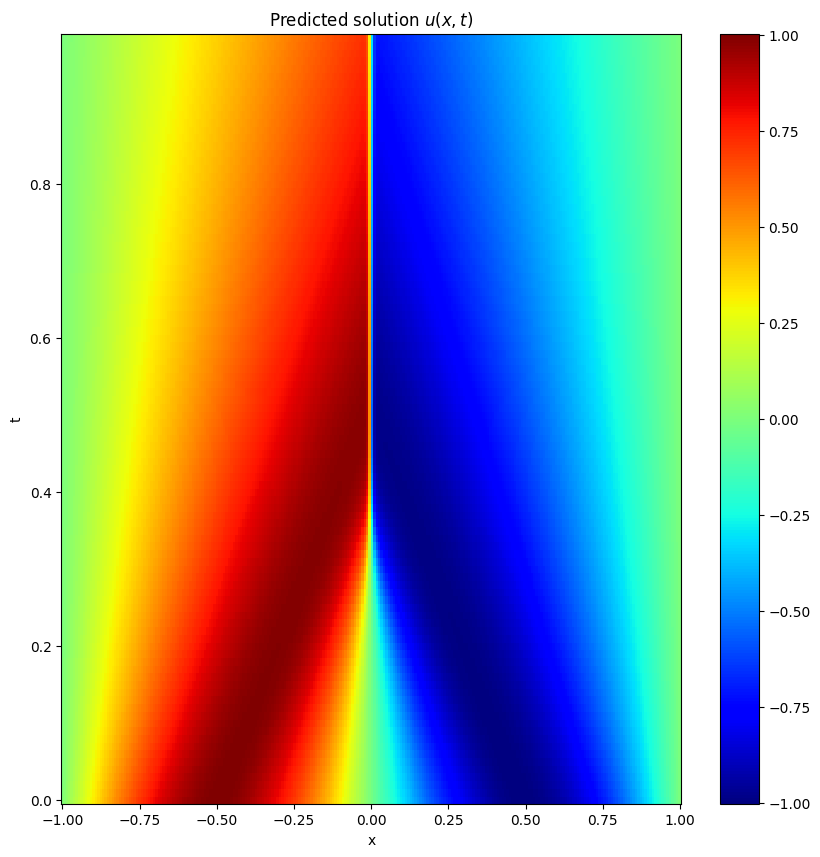

In [22]:
plt.figure(figsize=(10, 10))
plt.pcolor(X, T, u_pred.reshape(X.shape), cmap='jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted solution $u(x,t)$')
plt.show()